In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import datetime as dt
from collections import defaultdict
from datetime import date
from dateutil.relativedelta import relativedelta
from statsmodels.formula.api import ols

In [2]:
def calculate_assetg(group):
    # Shift within the group
    group['at_lag3'] = group['at'].shift(3)  
    group['at_lag2'] = group['at'].shift(2)
    group['at_lag1'] = group['at'].shift(1)


    # Calculate ASSETG
    group['ASSETG'] = (group['at_lag1'] - group['at_lag2']) / group['at_lag2']
    group['L2ASSETG'] = (group['at_lag2'] - group['at_lag3']) / group['at_lag3']
    return group

### Query 1
grabs total asset data, drops and reformats columns, removes SIC codes between 6000 & 6999 (financial), removes outliers, drops all NA & 0 at values, drops first two years, ensures continuity in years. Performs ASSETG calculations

* Date range: 1960-06-30/2005-06-30
* Company Codes: SIC
* Consolidation Level: consolidated: Parent and Subsidiary accounts combined
* Industry format: INDL: industrial
* Data format: STD: standardized
* Population source: D: domestic
* SELECT: SIC, gvkey, date, at

remove outlier by date based on prior data

In [ ]:
ASSETG_data_df = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_Rep\ASSETG_data.csv")
ASSETG_data_df = ASSETG_data_df[ASSETG_data_df['gvkey'] != 6557]
ASSETG_data_df = ASSETG_data_df[(ASSETG_data_df['sic'] < 6000) | (ASSETG_data_df['sic'] >= 6999)]
ASSETG_data_df['datadate'] = pd.to_datetime(ASSETG_data_df['datadate'])
ASSETG_data_df['year'] = ASSETG_data_df['fyear']
ASSETG_data_df = ASSETG_data_df.drop(['datadate', 'indfmt', 'popsrc','curcd', 'costat', 'consol','datafmt','fyear'], axis=1)
ASSETG_data_df = ASSETG_data_df.dropna()
ASSETG_data_df = ASSETG_data_df[ASSETG_data_df['at'] != 0]
ASSETG_data_df['at'] = ASSETG_data_df.groupby('gvkey')['at'].shift(1)
ASSETG_data_df['year_diff'] = ASSETG_data_df.groupby('gvkey')['year'].diff()

invalid_year_diff_mask = ASSETG_data_df.groupby('gvkey')['year_diff'].transform(lambda x: ((x != 1) & x.notna()).any())
ASSETG_data_df= ASSETG_data_df[~invalid_year_diff_mask]

ASSETG_data_df = ASSETG_data_df.groupby('gvkey').apply(lambda x: x.iloc[2:]).reset_index(drop=True)

ASSETG_calculated_df = ASSETG_data_df.groupby('gvkey').apply(calculate_assetg)
ASSETG_calculated_df = ASSETG_calculated_df.dropna()
ASSETG_calculated_df = ASSETG_calculated_df.droplevel(level=0)
ASSETG_calculated_df = ASSETG_calculated_df.drop(['at_lag3','at_lag2','at_lag1','year_diff'], axis=1)
ASSETG_calculated_df = ASSETG_calculated_df[(ASSETG_calculated_df['year'] >= 1968) & (ASSETG_calculated_df['year'] <= 2002)]
outliers = ASSETG_calculated_df['L2ASSETG'].quantile(0.999)
ASSETG_calculated_df = ASSETG_calculated_df[ASSETG_calculated_df['L2ASSETG'] <= outliers]

Plotting Statistics

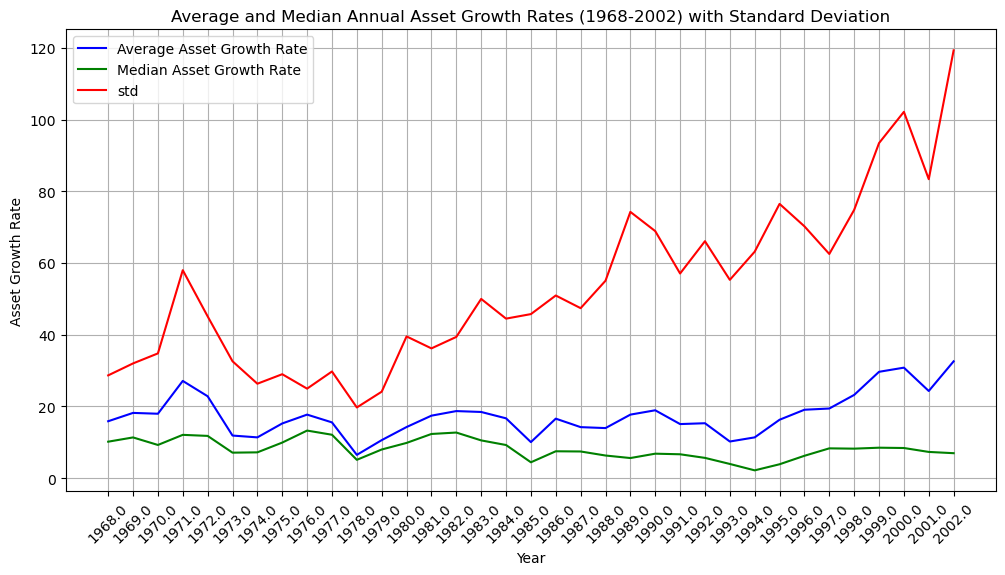

In [4]:
annual_stats = ASSETG_calculated_df.groupby('year')['L2ASSETG'].agg(['mean', 'median', 'std'])

plt.figure(figsize=(12, 6))

plt.plot(annual_stats.index, annual_stats['mean'] * 100, label='Average Asset Growth Rate', color='blue')
plt.plot(annual_stats.index, annual_stats['median'] * 100, label='Median Asset Growth Rate', color='green')
plt.plot(annual_stats.index, annual_stats['std'] * 100, label='std', color='red')

n = 1  # Adjust n as needed for clarity
plt.xticks(annual_stats.index[::n], annual_stats.index[::n], rotation=45)

plt.xlabel('Year')
plt.ylabel('Asset Growth Rate')
plt.title('Average and Median Annual Asset Growth Rates (1968-2002) with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

## Table II A: Asset Growth Panel
* Creates deciles
* Creates dictionary: gvkey(year(ASSETG:x, decile:x)
* For each unique gvkey: checks that iterated year has valid period, grabs decile of iterated year and for each year surrounding it grabs associated ASSETG, sums it with associated decile and offset year key, counts the amount of times its iterated, calculates averages

In [5]:
def has_complete_data_for_period(data_dict, gvkey, center_year):
    for year_offset in range(-4, 6):  # 10-year window: 4 years back, 5 years forward
        year = center_year + year_offset
        if year not in data_dict[gvkey]:
            return False  # Data for this year is missing or incomplete
    return True  # All years in the period have the necessary data

In [6]:
ASSETG_calculated_df_copy = ASSETG_calculated_df.copy()
ASSETG_calculated_df_copy['decile'] = pd.qcut(ASSETG_calculated_df_copy['ASSETG'], 10, labels=False)

data_dict = defaultdict(lambda: defaultdict(dict))
for idx, row in ASSETG_calculated_df_copy.iterrows():
    data_dict[row['gvkey']][row['year']] = {'ASSETG': row['ASSETG'], 'decile': row['decile']}

#Averaging Logic
sum_data = defaultdict(lambda: defaultdict(int))
count_data = defaultdict(lambda: defaultdict(int))
average_data = defaultdict(lambda: defaultdict(float))

for gvkey in tqdm(ASSETG_calculated_df_copy['gvkey'].unique(), desc='Processing stocks'):
    min_year = int(min(data_dict[gvkey]) + 4)
    max_year = int(max(data_dict[gvkey]) - 5)
    for center_year in range(min_year, max_year + 1):
        if has_complete_data_for_period(data_dict, gvkey, center_year):
            center_year_decile = data_dict[gvkey][center_year]['decile']
            for year_offset in range(-4, 6):
                year = center_year + year_offset
                
                if year in data_dict[gvkey]:
                    assetg_value = data_dict[gvkey][year]['ASSETG']

                    # Update sum and count
                    sum_data[center_year_decile][year_offset] += assetg_value
                    count_data[center_year_decile][year_offset] += 1

                    # Calculate and update the average
                    current_sum = sum_data[center_year_decile][year_offset]
                    current_count = count_data[center_year_decile][year_offset]
                    average_data[center_year_decile][year_offset] = current_sum / current_count if current_count != 0 else 0
data_for_df = {}
for year_offset in range(-4, 6):
    row_data = []
    for decile in range(10):
            row_data.append(average_data[decile][year_offset])
    data_for_df[year_offset] = row_data

ASSETG_decile_panel_df = pd.DataFrame(data_for_df, index=range(10)).transpose()
ASSETG_decile_panel_df.columns = [f'Decile {i}' for i in range(10)]
ASSETG_decile_panel_df.index.name = 'Year Offset'
ASSETG_decile_panel_df['9-0 Spread'] = ASSETG_decile_panel_df['Decile 9'] - ASSETG_decile_panel_df['Decile 0']

ASSETG_decile_panel_df

Processing stocks: 100%|██████████| 13747/13747 [00:00<00:00, 18095.66it/s]


,Decile 0,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,9-0 Spread
Year Offset,,,,,,,,,,,
-4,0.186914,0.146274,0.129784,0.122615,0.129117,0.129209,0.136109,0.154841,0.175147,0.178861,-0.008053
-3,0.157562,0.135215,0.115503,0.111360,0.114747,0.122533,0.135565,0.151075,0.174794,0.193069,0.035507
-2,0.115101,0.107280,0.095108,0.097185,0.107548,0.120651,0.134330,0.157102,0.184426,0.219346,0.104245
-1,0.035033,0.062937,0.081243,0.086499,0.096002,0.114024,0.133493,0.161204,0.218304,0.270465,0.235432
0,-0.278324,-0.079993,-0.014481,0.025327,0.058644,0.093742,0.135552,0.197056,0.318446,0.982506,1.260830
1,0.060241,0.037119,0.064550,0.080820,0.091463,0.116141,0.137288,0.170067,0.217574,0.248327,0.188087
2,0.123387,0.080082,0.079836,0.089178,0.095088,0.111842,0.125136,0.143836,0.174202,0.193790,0.070403
3,0.143137,0.093327,0.094764,0.094245,0.097613,0.104915,0.114242,0.128589,0.155353,0.181447,0.038310
4,0.172203,0.124116,0.087499,0.079925,0.093409,0.102298,0.106331,0.122940,0.131705,0.150723,-0.021481


### Query 2
grabs CRSP monthly stock return files, abs(prc), drops non-numeric instances, removes SIC in (5999,7000), calculates mv and shifts values to correspond with start of month, removes first two years of observations, ensures continuity in years & months

* Date range: 1960-06/2005-06
* Company Codes: PERMNO
* SELECT: permno, ret, prc, shrout

In [7]:
RET_data_df = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_Rep\RET_data.csv")
RET_data_df['PRC'] = RET_data_df['PRC'].abs()
RET_data_df['date'] = pd.to_datetime(RET_data_df['date'])
RET_data_df = RET_data_df.dropna()

# Function to check if a cell contains a non-numeric value & removes instances
def contains_char(cell):
    if pd.isnull(cell):
        return False
    try:
        float(cell)
        return False
    except ValueError:
        return True
    
columns_to_check = ['PERMNO', 'SICCD', 'PRC', 'RET', 'SHROUT']
for column in columns_to_check:
    RET_data_df = RET_data_df[~RET_data_df[column].apply(contains_char)]


siccd_numeric = pd.to_numeric(RET_data_df['SICCD'], errors='coerce')
RET_data_df = RET_data_df[(siccd_numeric < 6000) | (siccd_numeric >= 6999)]
RET_data_df['mv'] = RET_data_df['PRC'] * RET_data_df['SHROUT']

columns_to_shift = ['SICCD', 'PRC', 'RET', 'SHROUT', 'mv']
RET_data_df[columns_to_shift] = RET_data_df.groupby('PERMNO')[columns_to_shift].shift(1)
RET_data_df = RET_data_df.dropna()
RET_data_df['date'] = RET_data_df['date'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=1))

RET_data_df['year'] = RET_data_df['date'].dt.year

first_two_years = RET_data_df.groupby('PERMNO')['year'].unique().apply(lambda x: sorted(x)[:2])
mask = RET_data_df.apply(lambda row: row['year'] not in first_two_years.loc[row['PERMNO']], axis=1)
RET_data_df = RET_data_df[mask]

RET_data_df['year_diff'] = RET_data_df.groupby('PERMNO')['year'].diff()

invalid_year_diff_mask = RET_data_df.groupby('PERMNO')['year_diff'].transform(lambda x: ((x != 0) & (x != 1) & x.notna()).any())
RET_data_df= RET_data_df[~invalid_year_diff_mask]

RET_data_df['month'] = RET_data_df['date'].dt.month
month_counts_per_year = RET_data_df.groupby(['PERMNO', 'year'])['month'].nunique().reset_index(name='unique_month_count')
incomplete_years = month_counts_per_year[month_counts_per_year['unique_month_count'] != 12]
permnos_to_exclude = incomplete_years['PERMNO'].unique()
RET_data_df = RET_data_df[RET_data_df['PERMNO'].isin(permnos_to_exclude)]
RET_data_df['RET'] = pd.to_numeric(RET_data_df['RET'], errors='coerce')

C:\Users\mfcfi\AppData\Local\Temp\ipykernel_38184\11731192.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  RET_data_df = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_Rep\RET_data.csv")


### Query 3: Linking Table

In [8]:
linking_table = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_Rep\linking_table.csv")
linking_table = linking_table.dropna(subset=['lpermno'])
linking_table['linkdt'] = pd.to_datetime(linking_table['linkdt'])
linking_table['linkenddt'] = pd.to_datetime(linking_table['linkenddt'])

## Table II B: Logic: Average Monthly Returns
For each unique gvkey: 
* checks that iterated year has valid period
* grabs decile of iterated year and for each year surrounding it grabs associated average monthly return
* sums it with associated decile and offset year key, counts the amount of times its iterated, calculates averages

Calculate yearly return & average monthly return starting at July of t-1 to start June of year t, Merge return df with linking table to grab associated gvkeys, merge ASSETG df with return df to match t year returns with t-1 asset data

In [9]:
RET_data_df['shifted_year'] = np.where(RET_data_df['month'] >= 8, RET_data_df['year'] + 1, RET_data_df['year'])
filtered_df = RET_data_df[((RET_data_df['month'] >= 8) | (RET_data_df['month'] <= 6))]

def calc_yearly_return(x):
    return np.prod(1 + x) - 1

RET_aggregated_df = filtered_df.groupby(['PERMNO', 'shifted_year']).agg(
    average_monthly_RET=('RET', 'mean'),  # Calculate average monthly return
    yearly_return=('RET', calc_yearly_return),  # Calculate yearly return
    mv=('mv', 'last')
).reset_index()

RET_aggregated_df['date'] = pd.to_datetime(RET_aggregated_df['shifted_year'].astype(str) + '-06-01')
RET_aggregated_df.rename(columns={'shifted_year': 'year'}, inplace=True)
RET_aggregated_df = RET_aggregated_df[['PERMNO', 'year', 'date', 'average_monthly_RET', 'yearly_return','mv']]

RET_aggregated_linked_df = pd.merge(RET_aggregated_df, linking_table, how='left', left_on='PERMNO', right_on='lpermno')
valid_rows = RET_aggregated_linked_df.apply(lambda row: row['linkdt'] <= row['date'] <= (row['linkenddt'] if pd.notnull(row['linkenddt']) else pd.Timestamp('today')), axis=1)
RET_aggregated_linked_df = RET_aggregated_linked_df[valid_rows]
ASSETG_calculated_df['year'] = ASSETG_calculated_df['year'].astype(int)
ASSETG_RET_df = pd.merge(ASSETG_calculated_df, RET_aggregated_linked_df, how='inner', on=['gvkey', 'year'])
ASSETG_RET_df = ASSETG_RET_df.drop(['lpermno', 'linkdt', 'linkenddt','sic',],axis=1)
ASSETG_RET_df['decile'] = pd.qcut(ASSETG_RET_df['ASSETG'],10,labels=False)

Equal weight

In [10]:
equal_weight_sum_data = defaultdict(lambda: defaultdict(float))
equal_weight_count_data = defaultdict(lambda: defaultdict(int))
equal_weight_average_data = defaultdict(lambda: defaultdict(float))

data_dict = defaultdict(lambda: defaultdict(dict))
for idx, row in ASSETG_RET_df.iterrows():
    data_dict[row['gvkey']][row['year']] = {'average_monthly_RET': row['average_monthly_RET'], 'decile': row['decile']}

for gvkey in tqdm(ASSETG_RET_df['gvkey'].unique(), desc='Processing stocks'):
    min_year = min(data_dict[gvkey]) + 4
    max_year = max(data_dict[gvkey]) - 5

    for center_year in range(min_year, max_year + 1):
        if has_complete_data_for_period(data_dict, gvkey, center_year):
            center_year_decile = data_dict[gvkey][center_year]['decile']
            for year_offset in range(-4, 6):
                year = center_year + year_offset
                next_year = year + 1
                if next_year in data_dict[gvkey]:  # Ensure next year exists in data_dict for gvkey
                    monthly_average_return_value = data_dict[gvkey][next_year].get('average_monthly_RET', 0) 

                    # Update sums and counts for equal-weighted calculations
                    equal_weight_sum_data[center_year_decile][year_offset] += monthly_average_return_value
                    equal_weight_count_data[center_year_decile][year_offset] += 1


for center_year_decile in equal_weight_sum_data:
    for year_offset in equal_weight_sum_data[center_year_decile]:
        equal_weight_average_data[center_year_decile][year_offset] = equal_weight_sum_data[center_year_decile][year_offset] / equal_weight_count_data[center_year_decile][year_offset]
            
data_for_df = {}
for year_offset in range(-4, 6):
    row_data = []
    for decile in range(10):
            row_data.append(equal_weight_average_data[decile][year_offset])
    data_for_df[year_offset] = row_data

equal_monthly_decile_panel_df = pd.DataFrame(data_for_df, index=range(10)).transpose()
equal_monthly_decile_panel_df.columns = [f'Decile {i}' for i in range(10)]
equal_monthly_decile_panel_df.index.name = 'Year Offset'
equal_monthly_decile_panel_df['9-0 Spread'] = equal_monthly_decile_panel_df['Decile 9'] - equal_monthly_decile_panel_df['Decile 0']

equal_monthly_decile_panel_df

Processing stocks: 100%|██████████| 9726/9726 [00:00<00:00, 35158.28it/s]


,Decile 0,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,9-0 Spread
Year Offset,,,,,,,,,,,
-4,0.002114,0.006188,0.010120,0.011177,0.013075,0.014878,0.017385,0.021639,0.027404,0.031784,0.029670
-3,-0.000262,0.006222,0.008990,0.012167,0.013523,0.014331,0.016625,0.020801,0.027329,0.042826,0.043088
-2,0.016757,0.017429,0.015886,0.014560,0.014735,0.015528,0.014161,0.017804,0.021197,0.022765,0.006007
-1,0.022985,0.018066,0.015516,0.014446,0.014753,0.014180,0.014826,0.014832,0.015265,0.012512,-0.010473
0,0.021498,0.018183,0.016217,0.014928,0.014836,0.014619,0.013594,0.013524,0.014049,0.012450,-0.009048
1,0.021019,0.019621,0.015963,0.014587,0.014651,0.013997,0.014614,0.015125,0.014694,0.014426,-0.006593
2,0.020156,0.017050,0.016663,0.014971,0.014413,0.014399,0.014820,0.014322,0.015381,0.017246,-0.002910
3,0.018606,0.018500,0.015379,0.015062,0.014394,0.013993,0.013405,0.014403,0.015384,0.013035,-0.005571
4,0.016340,0.015075,0.013302,0.013838,0.014135,0.013795,0.013340,0.013315,0.013404,0.013666,-0.002673


Value weight

In [11]:
total_market_cap = defaultdict(float)
annual_weights = defaultdict(lambda: defaultdict(float))
weighted_sum_data = defaultdict(lambda: defaultdict(float))
value_weighted_average_data = defaultdict(lambda: defaultdict(float))

data_dict = defaultdict(lambda: defaultdict(dict))
for idx, row in ASSETG_RET_df.iterrows():
    data_dict[row['gvkey']][row['year']] = {'average_monthly_RET': row['average_monthly_RET'],'mv': row['mv'], 'decile': row['decile']}

for gvkey, yearly_data in data_dict.items():
    for year, attributes in yearly_data.items():
        # Total market value for each year
        total_market_cap[year] += attributes['mv']

for gvkey, yearly_data in data_dict.items():
    for year, attributes in yearly_data.items():
        # Calculate the weight of each gvkey for each year
        if total_market_cap[year] > 0:
            annual_weights[year][gvkey] = attributes['mv'] / total_market_cap[year]

for gvkey in tqdm(ASSETG_RET_df['gvkey'].unique(), desc='Processing stocks'):
    min_year = min(data_dict[gvkey]) + 4
    max_year = max(data_dict[gvkey]) - 5

    for center_year in range(min_year, max_year + 1):
        if has_complete_data_for_period(data_dict, gvkey, center_year):
            center_year_decile = data_dict[gvkey][center_year]['decile']
            for year_offset in range(-4, 6):
                year = center_year + year_offset
                next_year = year + 1
                if next_year in data_dict[gvkey]:
                    # Calculate weighted return
                    monthly_average_return_value = data_dict[gvkey][next_year].get('average_monthly_RET', 0) 
                    weight = annual_weights[year][gvkey]
                    weighted_return = monthly_average_return_value * weight

                    weighted_sum_data[center_year_decile][year_offset] += weighted_return

data_for_df = {}
for year_offset in range(-4, 6):
    row_data = []
    for decile in range(10):
            row_data.append(weighted_sum_data[decile][year_offset])
    data_for_df[year_offset] = row_data

weighted_monthly_decile_panel_df = pd.DataFrame(data_for_df, index=range(10)).transpose()
weighted_monthly_decile_panel_df.columns = [f'Decile {i}' for i in range(10)]
weighted_monthly_decile_panel_df.index.name = 'Year Offset'
weighted_monthly_decile_panel_df['9-0 Spread'] = weighted_monthly_decile_panel_df['Decile 9'] - weighted_monthly_decile_panel_df['Decile 0']

weighted_monthly_decile_panel_df

Processing stocks: 100%|██████████| 9726/9726 [00:00<00:00, 29918.31it/s]


,Decile 0,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,9-0 Spread
Year Offset,,,,,,,,,,,
-4,0.002941,0.006668,0.017538,0.018696,0.031917,0.032313,0.040398,0.029636,0.018640,0.009567,0.006627
-3,0.001624,0.003886,0.021488,0.022232,0.032861,0.038263,0.040441,0.029730,0.020713,0.008496,0.006873
-2,0.006377,0.013922,0.028591,0.027382,0.045200,0.047286,0.029459,0.023606,0.021963,0.010188,0.003811
-1,0.005864,0.011754,0.026321,0.029419,0.035897,0.043796,0.037504,0.022335,0.016737,0.009660,0.003797
0,0.006130,0.013104,0.028710,0.028663,0.035709,0.047319,0.040894,0.019453,0.018089,0.007135,0.001005
1,0.007117,0.014287,0.030173,0.030809,0.037993,0.051022,0.031971,0.025169,0.022915,0.008400,0.001283
2,0.004240,0.015384,0.027913,0.027561,0.038954,0.051408,0.045245,0.027879,0.025750,0.009794,0.005554
3,0.005008,0.012446,0.022709,0.027213,0.040058,0.042382,0.044655,0.033370,0.018118,0.009474,0.004466
4,0.003515,0.010473,0.019830,0.022075,0.037981,0.047510,0.044109,0.027855,0.019033,0.007452,0.003937


## Table II C: Year 1 Size Group Monthly Alphas
* merging monthly factors with monthly returns
* Takes center year ASSETG & does year 1 average monthly alphas for each decile

### Query 4

In [12]:
fac_3_df = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_Rep\fac_3.csv")
fac_3_df['date'] = fac_3_df['dateff']
fac_3_df['date'] = pd.to_datetime(fac_3_df['date'])
fac_3_df['date'] =fac_3_df['date'].dt.strftime('%Y-%m-01')
fac_3_df['date'] = pd.to_datetime(fac_3_df['date'])
fac_3_df = fac_3_df.drop(['dateff'], axis=1)
columns_to_shift = ['mktrf', 'smb', 'hml', 'rf']
fac_3_df[columns_to_shift] = fac_3_df[columns_to_shift].shift(1)
fac_3_df = fac_3_df.dropna()
fac_3_df

RET_fac_df = pd.merge(RET_data_df, fac_3_df, how='left', left_on='date', right_on='date')
ASSETG_RET_fac_df = pd.merge(RET_fac_df, ASSETG_RET_df[['PERMNO', 'year', 'ASSETG', 'L2ASSETG','decile']], on=['PERMNO', 'year'], how='left')

ASSETG_RET_fac_df = ASSETG_RET_fac_df.dropna()
ASSETG_RET_fac_df['RETrf'] = ASSETG_RET_fac_df['RET'] - ASSETG_RET_fac_df['rf']

In [13]:
data_dict = defaultdict(lambda: defaultdict(dict))
for idx, row in ASSETG_RET_fac_df.iterrows():
    month = row['date'].month
    year = row['shifted_year']
    data_dict[row['PERMNO']][year][month] = {
        'RETrf': row['RETrf'],
        'mktrf': row['mktrf'],
        'smb': row['smb'],
        'hml': row['hml'],
        'rf': row['rf'],
    }

In [ ]:
alpha_sum_data = defaultdict(lambda: defaultdict(float))
alpha_count_data = defaultdict(lambda: defaultdict(int))
alpha_monthly_average_data = defaultdict(lambda: defaultdict(float))

iterate_data_dict = defaultdict(lambda: defaultdict(dict))
for idx, row in ASSETG_RET_fac_df.iterrows():
    iterate_data_dict[row['PERMNO']][row['year']] = {'decile': row['decile']}

for PERMNO in tqdm(ASSETG_RET_fac_df['PERMNO'].unique(), desc='Processing stocks'):

    min_year = min(iterate_data_dict[PERMNO]) + 4
    max_year = max(iterate_data_dict[PERMNO]) - 5

    for center_year in range(min_year, max_year + 1):
        if has_complete_data_for_period(iterate_data_dict, PERMNO, center_year):
            center_year_decile = iterate_data_dict[PERMNO][center_year]['decile']
            year = center_year + 1
            next_year = year + 1
            if next_year in data_dict[PERMNO]:
              
              for month in data_dict[PERMNO][next_year]:
            
                    month_data = data_dict[PERMNO][next_year][month]
                    df_month_data = pd.DataFrame([month_data])
                    model = ols('RETrf ~ mktrf + smb + hml', data=df_month_data).fit()
                    alpha = model.params.Intercept
                    alpha_sum_data[center_year_decile][next_year] += alpha
                    alpha_count_data[center_year_decile][next_year] += 1

for decile in alpha_sum_data:
    for year in alpha_sum_data[decile]:
        if alpha_count_data[decile][year] > 0:
            alpha_monthly_average_data[decile][year] = alpha_sum_data[decile][year] / alpha_count_data[decile][year]

decile_averages = defaultdict(float)

for decile, year_data in alpha_monthly_average_data.items():
    if year_data:
        average = sum(year_data.values()) / len(year_data)
        decile_averages[decile] = average
            
data_for_df = {}
for decile in range(10):
    data_for_df[f'Decile {decile}'] = [decile_averages[decile]]  

alpha_monthly_decile_panel_df = pd.DataFrame(data_for_df, index=[0])  
alpha_monthly_decile_panel_df['9-0 Spread'] = alpha_monthly_decile_panel_df['Decile 9'] - alpha_monthly_decile_panel_df['Decile 0']

alpha_monthly_decile_panel_df
